<a href="https://colab.research.google.com/github/Ashwal-B-S/PlantDiseaseDetection/blob/main/EfficientDet_PlantDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/EfficientDetModeling/input/
!ls

/content/drive/MyDrive/EfficientNetModeling/input
plantdisease


In [ ]:
%cd /content/drive/MyDrive/EfficientDetModeling/working/
!ls

/content/drive/MyDrive/EfficientNetModeling/working
EfficientNet-PyTorch


In [ ]:
# !git clone https://github.com/lukemelas/EfficientDet-PyTorch
# %cd ./EfficientDet-PyTorch
# !pip install -e 

fatal: destination path 'EfficientNet-PyTorch' already exists and is not an empty directory.
/content/drive/MyDrive/EfficientNetModeling/working/EfficientNet-PyTorch/EfficientNet-PyTorch

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-e option requires 1 argument


In [ ]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

In [ ]:
import torch

if torch.cuda.is_available():
  print("GPU available")
  torch.backends.cudnn.deterministic = True

print(torch.cuda.is_available())

# !nvidia-smi # gpu 확인

GPU available
True


In [ ]:
!nvidia-smi # gpu 확인

Sat Jul 31 19:04:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 64

data_path = '/content/drive/MyDrive/PlantVillageDataset_MyDataset/PlantVillage'
leaf_datasets = datasets.ImageFolder(
    data_path,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [ ]:
random_seed = 33
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}

train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.4, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.5, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)

In [ ]:
print(len(dataset['train']))
print(len(dataset['valid']))

12400
4134


In [ ]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  test/valid : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  test/valid : 194 / 65 / 65


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
count = np.zeros(15)

for images, labels in dataloaders['train']:  
    for a in labels:
      count[a.numpy()] += 1

print(count)


v_count = np.zeros(15)

for images, labels in dataloaders['valid']:  
    for a in labels:
      v_count[a.numpy()] += 1

print(v_count)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


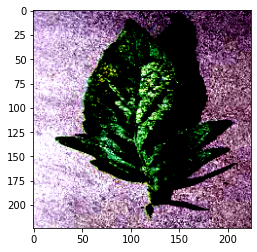

In [ ]:
imgtest = None
for images, labels in dataloaders['train']:  
    imgtest = images[3]
    print(imgtest.shape)
    break

imgtest = imgtest.numpy()
imgtest = np.moveaxis(imgtest, 0, -1)
imshow(imgtest)

In [ ]:
%cd /content/drive/MyDrive/EfficientDetModeling/working/EfficientDet-PyTorch

from efficientdet_pytorch import EfficientDet
# model = EfficientDet.from_pretrained('efficientdet-b0', num_classes=15)
model = EfficientDet.from_name('efficientdet-b0', num_classes=15)

for param in model.parameters():
    param.requires_grad = True

dev = torch.device("cuda") 

/content/drive/MyDrive/EfficientNetModeling/working/EfficientNet-PyTorch


In [ ]:
model = model.to(dev)

optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 70
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0

since = time.time()
best_model = copy.deepcopy(model.state_dict())


for epoch in range(num_epochs):    
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        output = model(data)                
    
        loss = criterion(output, target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(output, 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.008)
    val_acc_list.append(val_corrects * 0.0242)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.0242 > best_acc:
      best_acc = val_corrects * 0.0242
      best_model = copy.deepcopy(model.state_dict())
      print("best model updated-epoch: {} | val_accuracy: {:.4f}".format(epoch+1, best_acc))


time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best valid Acc: %.1f' %(best_acc))

model.load_state_dict(best_model)
torch.save(model.state_dict(), '/content/drive/MyDrive/EfficientDetModeling/working/best_model.pt')
print("model saved")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 1/70 | trn loss: 2.4568 | val loss: 2.6392 | 18m 46s elapsed
best model updated-epoch: 1 | val_accuracy: 16.3108
epoch: 2/70 | trn loss: 2.2362 | val loss: 2.6986 | 19m 53s elapsed
epoch: 3/70 | trn loss: 1.9828 | val loss: 2.6725 | 20m 60s elapsed
best model updated-epoch: 3 | val_accuracy: 23.7644
epoch: 4/70 | trn loss: 1.6878 | val loss: 1.4998 | 22m 8s elapsed
best model updated-epoch: 4 | val_accuracy: 50.1666
epoch: 5/70 | trn loss: 1.4453 | val loss: 1.2600 | 23m 15s elapsed
best model updated-epoch: 5 | val_accuracy: 57.5476
epoch: 6/70 | trn loss: 1.2676 | val loss: 1.1408 | 24m 22s elapsed
best model updated-epoch: 6 | val_accuracy: 60.9598
epoch: 7/70 | trn loss: 1.1307 | val loss: 0.9818 | 25m 29s elapsed
best model updated-epoch: 7 | val_accuracy: 66.9130
epoch: 8/70 | trn loss: 0.9997 | val loss: 0.9168 | 26m 37s elapsed
best model updated-epoch: 8 | val_accuracy: 69.3088
epoch: 9/70 | trn loss: 0.8943 | val loss: 0.8329 | 27m 44s elapsed
best model updated-epoch:

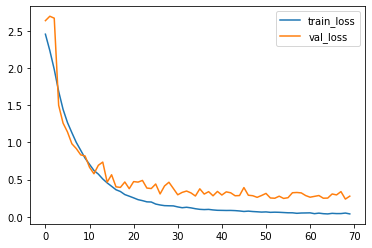

In [ ]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

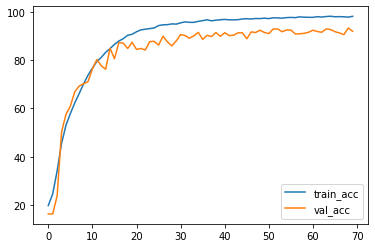

In [ ]:
plt.plot(trn_acc_list, label='train_acc')
plt.plot(val_acc_list, label='val_acc')
plt.legend()

In [ ]:
best_model = EfficientDet.from_name('efficientdet-b0', num_classes=15)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/EfficientDetModeling/working/best_model.pt'))

best_model.to(dev)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
corrects = 0
total = 0

model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = best_model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)
        
print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


3729/4134 | test accuracy: 0.9020
